In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import statsmodels as sm
import statsmodels.api as smt
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.tsa.stattools as st 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt

In [2]:
df = pd.read_csv('unemployment_Rate_train.csv')
df

,DATE,UnemploymentRate
0,2/1/1978,4.657080
1,3/1/1978,4.337432
2,4/1/1978,4.191995
3,5/1/1978,4.267247
4,6/1/1978,4.290661
...,...,...
404,10/1/2011,3.942588
405,11/1/2011,3.925562
406,12/1/2011,3.717759
407,1/1/2012,4.136666


In [3]:
test = pd.read_csv('unemployment_Rate_test.csv')
#test

In [4]:
# Convert the data into datetime
df['DATE']=pd.to_datetime(df['DATE']) 
df.set_index('DATE', inplace=True)
df

,UnemploymentRate
DATE,
1978-02-01,4.657080
1978-03-01,4.337432
1978-04-01,4.191995
1978-05-01,4.267247
1978-06-01,4.290661
...,...
2011-10-01,3.942588
2011-11-01,3.925562
2011-12-01,3.717759


In [5]:
# check if there are missing values
df.isnull().sum()

UnemploymentRate    0
dtype: int64

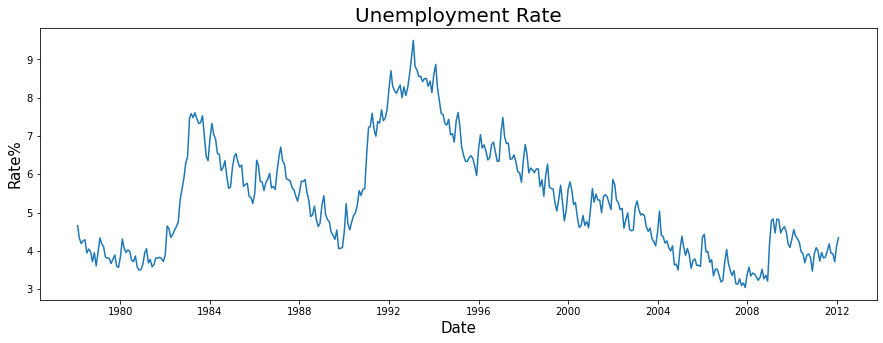

In [6]:
#original data，time series plot
rate = df['UnemploymentRate']
plt.figure(figsize = (15,5))
plt.plot(rate)
plt.title('Unemployment Rate',fontsize = 20)       # Add title to the plot
plt.xlabel('Date',fontsize = 15)             # Add label to the x-axis
plt.ylabel('Rate%',fontsize = 15)            # Add label to the y-axis
plt.show()
#plt.savefig('Unemployment Rate.PNG')

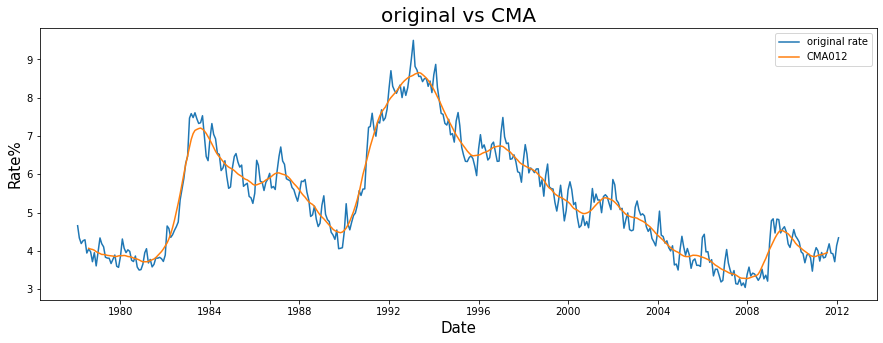

In [7]:
cma = rate.rolling(12, center = True).mean().rolling(2, center = True).mean().shift(-1)
plt.figure(figsize = (15,5))
plt.plot(rate,label="original rate")
plt.plot(cma,label="CMA012")
plt.title("original vs CMA", fontsize = 20)
plt.xlabel('Date', fontsize = 15 )
plt.ylabel('Rate%', fontsize = 15)
plt.legend()
plt.show()

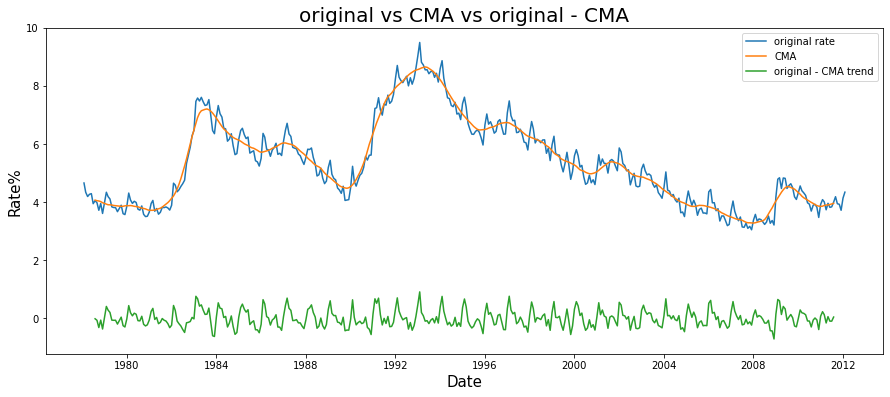

In [8]:
remove_trend = rate - cma
# Plot the de-trended and original series
plt.figure(figsize = (15,6))
plt.plot(rate,label="original rate")
plt.plot(cma,label="CMA")
plt.plot(remove_trend,label="original - CMA trend")
plt.title("original vs CMA vs original - CMA", fontsize = 20)
plt.xlabel('Date', fontsize = 15 )
plt.ylabel('Rate%', fontsize = 15)
plt.legend()
plt.show()
#plt.savefig('original vs CMA vs original - CMA .PNG')

In [9]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    # Print test outputs
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','pvalue','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


test_stationarity(remove_trend.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -6.687711e+00
pvalue                         4.185083e-09
#Lags Used                     1.700000e+01
Number of Observations Used    3.790000e+02
Critical Value (1%)           -3.447722e+00
Critical Value (5%)           -2.869196e+00
Critical Value (10%)          -2.570849e+00
dtype: float64


- H0: time series not stationary
- H1: time series stationary
- p-value <0.05  thus, it is stationarity 

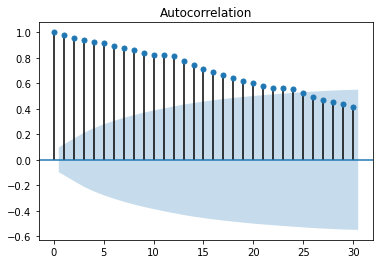

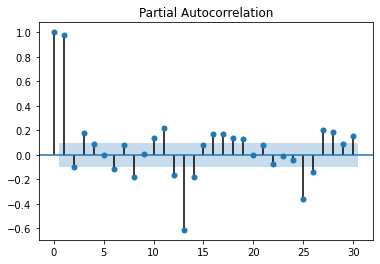

In [10]:
#original time series
import statsmodels as sm
import statsmodels.api as smt
from pandas.plotting import autocorrelation_plot
smt.graphics.tsa.plot_acf(rate.dropna(), lags=30, alpha = 0.05)

smt.graphics.tsa.plot_pacf(rate.dropna(), lags=30, alpha=0.05)
plt.show()
#If the Sample ACF of a non-seasonal time series “dies down" 
#extremely slowly or not at all, then the time series 
#should be considered nonstationary.

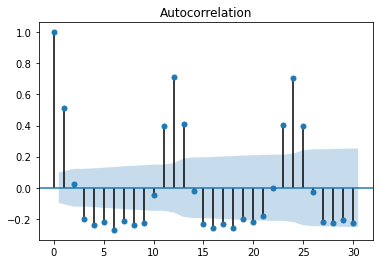

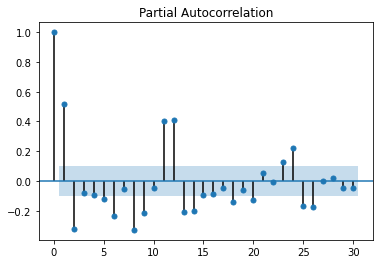

In [11]:
#de-trend time series
import statsmodels as sm
import statsmodels.api as smt
from pandas.plotting import autocorrelation_plot
smt.graphics.tsa.plot_acf(remove_trend.dropna(), lags=30, alpha = 0.05)

smt.graphics.tsa.plot_pacf(remove_trend.dropna(), lags=30, alpha=0.05)
plt.show()
#If the Sample ACF of a non-seasonal time series “dies down" 
#extremely slowly or not at all, then the time series 
#should be considered nonstationary.

# model

## Additive Decomposition

In [12]:
train = rate[:-48] #y1...y361
val = rate[-48:] #362...y409 #as forecast 48 

In [13]:
# Initially estimate the Trend component
Trend = train.rolling(12, center = True).mean().rolling(2, center = True).mean().shift(-1)

# Obtain the de-trended series. This is an approximation of the seasonal component
S_additive = train - Trend

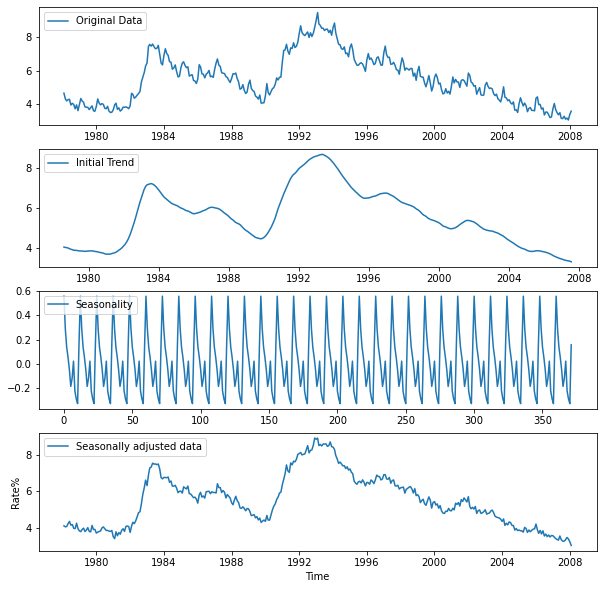

In [14]:
# Replace missing values in the S_additive by zeros

S_non_zeros = np.nan_to_num(S_additive)

# Add 11 zeros to the end of S_additive and convert S_additive to a 31*12 matrix
S_monthly =np.concatenate((S_non_zeros, [0,0,0,0,0,0,0,0,0,0,0])).reshape((31,12)) # 31年 * 12个月 

# Calculate column averages
S_monthly_avg = S_monthly[1:29,:].mean(axis=0)

# Normalize the seasonal index
mean_allmonth = S_monthly_avg.mean()
S_monthly_avg_normed = S_monthly_avg - mean_allmonth

# Replicate the normalized seasonal index array 31 times (31 years)
S_tiled_avg = np.tile(S_monthly_avg_normed, 31)

# Subtract the seasonal average from the original data to obtain the seasonally adjusted data 
seasonally_adjusted = train - S_tiled_avg[:-11]

# Plot the original data together with trend and seasonality
fig, ax = plt.subplots(4, 1,figsize=(10,10))
ax[0].plot(train)
ax[1].plot(Trend)
ax[2].plot(S_tiled_avg)
ax[3].plot(seasonally_adjusted)
ax[0].legend(['Original Data'], loc=2)
ax[1].legend(['Initial Trend'], loc=2)
ax[2].legend(['Seasonality'], loc=2)
ax[3].legend(['Seasonally adjusted data'], loc=2)
plt.xlabel('Time')
plt.ylabel('Rate%')
plt.show()
#plt.savefig('Original Data,Initial Trend,Seasonality,Seasonally adjusted data .PNG')

In [15]:
# model the trend
# trend
y_trend = seasonally_adjusted.values.reshape(-1,1)

# time step
x = np.arange(1,len(train)+1).reshape(-1,1)
x_train = np.hstack((x,x**2,x**3,x**4)) 

from sklearn.linear_model import LinearRegression
regression = LinearRegression()
square_trend = regression.fit(x_train,y_trend)

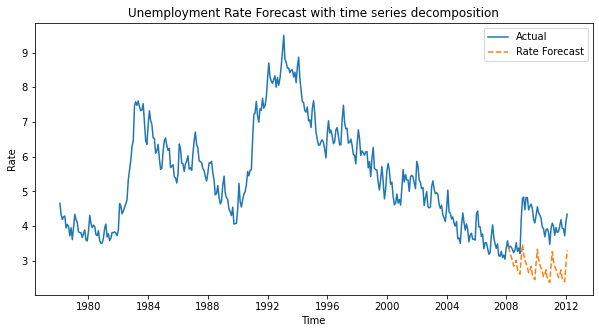

In [16]:
num_test = 48   # Out-of-sample size (48 months)
x_new = np.arange(len(train)+1,len(train)+1+num_test).reshape(-1,1)
x_train_new = np.hstack((x_new,x_new**2,x_new**3,x_new**4))

Trend_forecast = regression.predict(x_train_new)

S_tiled_avg = np.tile(S_monthly_avg_normed, 5)[1:49]

# Forecast 
S_forecast = Trend_forecast + S_tiled_avg.reshape(-1,1)

# Plot the forecast rate
plt.figure(figsize=(10,5))
plt.plot(rate.index,rate, label="Actual")
plt.plot(val.index,S_forecast, linestyle='--', label="Rate Forecast")
plt.title("Unemployment Rate Forecast with time series decomposition")
plt.xlabel("Time")
plt.ylabel('Rate')
plt.legend()
plt.show()

In [17]:
mse_decomposition = mse(val.values.reshape(-1,1),S_forecast)

print("MSE in Add decomposition {:.4f}".format(mse_decomposition))

rmse_decomposition = sqrt(mse_decomposition)
print("RMSE in Add decomposition {:.4f}".format(rmse_decomposition))

MSE in Add decomposition 1.6263
RMSE in Add decomposition 1.2753


## SES

In [18]:
def sse(x, y):
    return np.sum(np.power(x-y,2))
sse_one = []
alphas = np.arange(0.01,1,0.01)

for i in alphas:
    smoothed = rate.ewm(alpha = i, adjust=False).mean()
    sse_one.append(sse(smoothed[:-1], rate.values[1:]))

In [19]:
optimal_alpha_one = alphas[np.argmin(sse_one)]
print("Optimal Alpha for 1-step forecast {:.2f}".format(optimal_alpha_one))

Optimal Alpha for 1-step forecast 0.99


In [20]:
def SES(y,alpha):
    smoothed_manual = [y[0]]
    for i in range(len(y)):
        smoothed_manual.append(alpha*y[i]+(1- alpha)*smoothed_manual[i])
    return smoothed_manual

In [21]:
train = train.tolist()

for i in range(len(val)):
    prediction = SES(train,optimal_alpha_one)[-1]
    train.append(prediction)
    
y_pred = train[-48:]


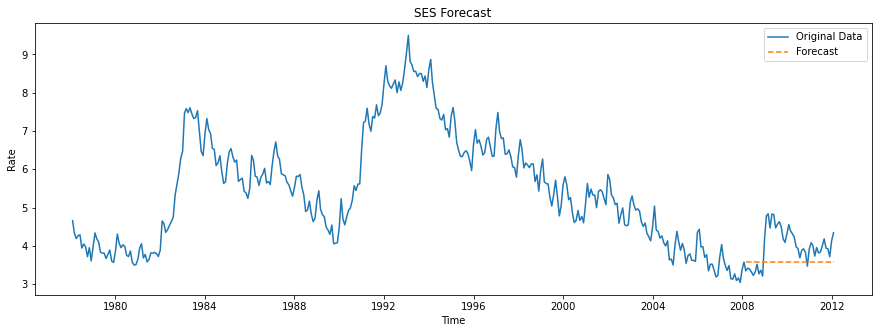

In [22]:
SES_predict = pd.Series(y_pred,index= val.index)
plt.figure(figsize=(15,5))
plt.plot(rate, label = "Original Data")
plt.plot(SES_predict[-48:],linestyle='--', label = "Forecast")
plt.xlabel('Time')
plt.ylabel('Rate')
plt.title('SES Forecast')
plt.legend()
plt.show()

In [23]:
mse_SES = mse(val.values.reshape(-1,1),y_pred)

print("MSE in SES {:.4f}".format(mse_SES))
rmse_SES = sqrt(mse_SES)
print("RMSE in SES {:.4f}".format(rmse_SES))

MSE in SES 0.3899
RMSE in SES 0.6244


## Holt-Winters smoothing

In [24]:
fit_add = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add').fit() # Holt-Winters additive smoothing
#fit_mul = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul').fit() # Holt-Winters multiplicative  smoothing

In [25]:
fit_add.params['smoothing_level']

0.8415076129510553

In [26]:
results = pd.DataFrame(index=[r"$\alpha$",\
                              r"$\beta$",\
                              r"$\gamma$",\
                              r"$l_0$",\
                              "$b_0$",\
                              "SSE"])
# ExponentialSmoothing() object has following attributes
params = ['smoothing_level', \
          'smoothing_slope', \
          'smoothing_seasonal', \
          'initial_level', \
          'initial_slope']

# check out the performance of additive and multiplicative
results["Additive"]       = [fit_add.params[p] for p in params] + [fit_add.sse]
#results["Multiplicative"] = [fit_mul.params[p] for p in params] + [fit_mul.sse]
print(results)

           Additive
$\alpha$   0.841508
$\beta$    0.100969
$\gamma$   0.022320
$l_0$      5.814087
$b_0$      0.000000
SSE       15.430734


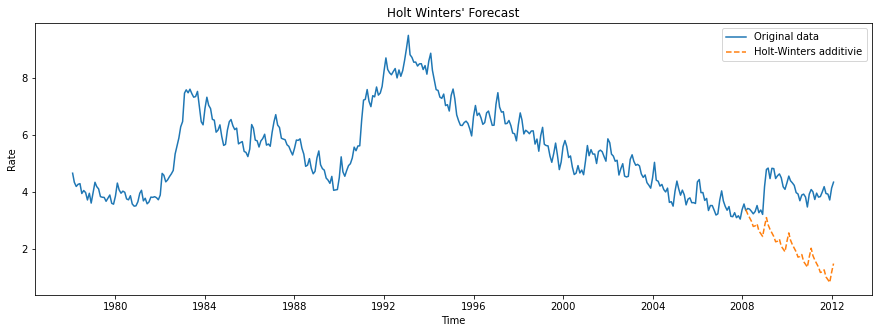

In [27]:
# Obtain fitted values from the fittedvalues attribute
forecast_add = fit_add.forecast(len(val)) 
#forecast_mul = fit_mul.forecast(len(val)) 

# Plot all together
plt.figure(figsize=(15,5))
plt.plot(rate.index, rate, label = 'Original data')
plt.plot(val.index,forecast_add, linestyle='--',label = 'Holt-Winters additivie')
#plt.plot(val.index,forecast_mul, linestyle='--', label = 'Holt-Winters multiplicative')
plt.xlabel("Time")
plt.ylabel('Rate')
plt.title("Holt Winters' Forecast")
plt.legend()
plt.show()
#plt.savefig('Unemployment Rate Forecast in Holt Winter .PNG')

In [28]:
mse_add = mse(forecast_add,val)
#mse_mul = mse(forecast_mul,val)
print("MSE in add {:.4f}".format(mse_add))
#print("MSE in mul {:.4f}".format(mse_mul ))

rmse_add = sqrt(mse_add)
#rmse_mul = sqrt(mse_mul)
print("RMSE in add {:.4f}".format(rmse_add))
#print("RMSE in mul {:.4f}".format(rmse_mul))

MSE in add 4.3473
RMSE in add 2.0850


## ARIMA Model

In [29]:
train = rate[:-48]
val = rate[-48:]

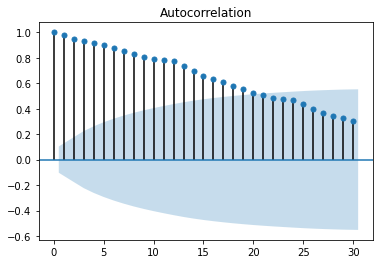

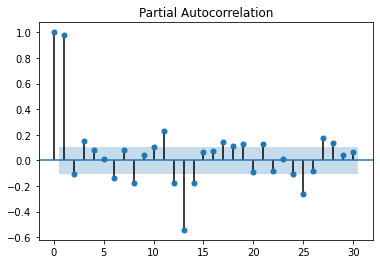

In [30]:
# Plot the ACF for the data. This call opens a new plot
smt.graphics.tsa.plot_acf(train, lags=30, alpha = 0.05) 

# Plot the PACF for the data. This call opens a new plot
smt.graphics.tsa.plot_pacf(train, lags=30, alpha=0.05)

plt.show()

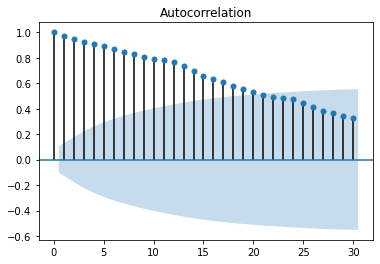

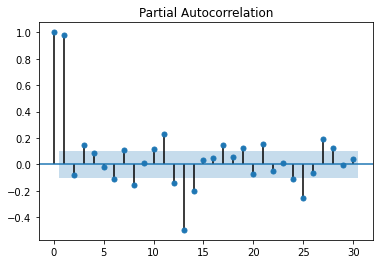

In [31]:
log = np.log(train)

smt.graphics.tsa.plot_acf(log, lags=30, alpha = 0.05) 


smt.graphics.tsa.plot_pacf(log, lags=30, alpha=0.05)

plt.show()

In [32]:
test_stationarity(log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.676749
pvalue                           0.443130
#Lags Used                      17.000000
Number of Observations Used    343.000000
Critical Value (1%)             -3.449560
Critical Value (5%)             -2.870004
Critical Value (10%)            -2.571279
dtype: float64


In [33]:
# 1st order differencing
train - train.shift()

DATE
1978-02-01         NaN
1978-03-01   -0.319648
1978-04-01   -0.145437
1978-05-01    0.075252
1978-06-01    0.023414
                ...   
2007-10-01   -0.175206
2007-11-01    0.067881
2007-12-01   -0.117551
2008-01-01    0.334303
2008-02-01    0.196398
Name: UnemploymentRate, Length: 361, dtype: float64

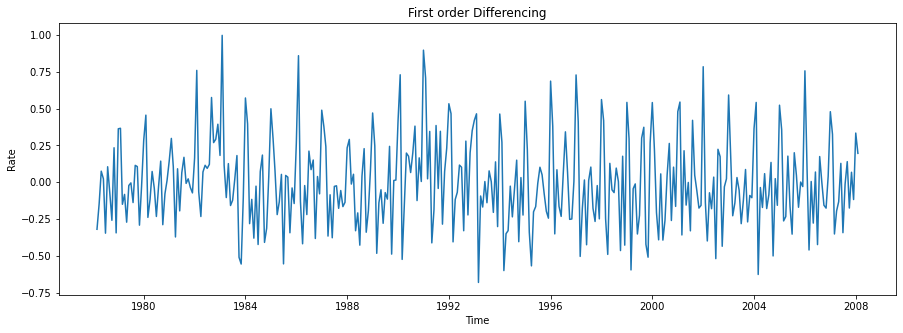

In [34]:
# take the 1st order diff
train_diff = train - train.shift()
train_diff.dropna(inplace=True)

# Plot the 1st-differencing series
plt.figure(figsize=(15,5))
plt.plot(train_diff,label = 'time series data')
plt.xlabel("Time")
plt.ylabel('Rate')
plt.title("First order Differencing")
plt.show()
#plt.savefig('First order Differencing .PNG')

In [35]:
test_stationarity(train_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -4.831525
pvalue                           0.000047
#Lags Used                      17.000000
Number of Observations Used    342.000000
Critical Value (1%)             -3.449616
Critical Value (5%)             -2.870028
Critical Value (10%)            -2.571292
dtype: float64


- H0: time series not stationary
- H1: time series stationary
- p-value <0.05  thus, it is stationarity

In [36]:

import statsmodels.tsa.stattools as st 

order = st.arma_order_select_ic(train_diff,max_ar=5,max_ma=5,ic=['aic'])
print(order.aic_min_order)

/Users/ming/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or

(5, 4)


/Users/ming/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


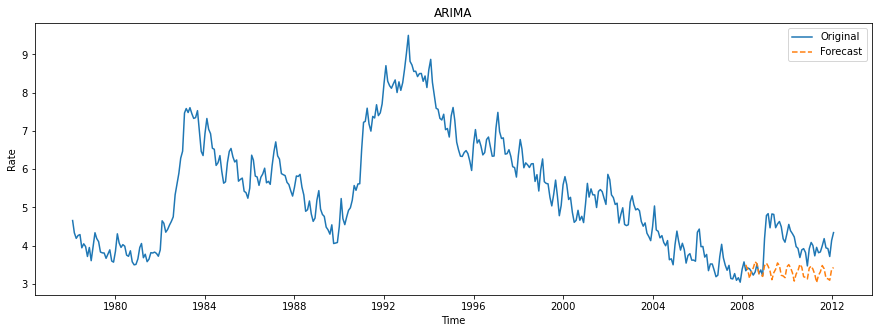

In [37]:
p,q = 5,4
model_AIC = ARIMA(train, order=(p, 1, q))

results_AIC_ARIMA = model_AIC.fit(disp=-1)
residuals_AIC = pd.DataFrame(results_AIC_ARIMA.resid)

predict,_,_ = results_AIC_ARIMA.forecast(len(val))

# Plot forecast and true values
plt.figure(figsize=(15,5))
plt.plot(rate,label='Original')
plt.plot(val.index, predict,linestyle='--',label='Forecast')
plt.title('ARIMA')
plt.xlabel("Time")
plt.ylabel('Rate')
plt.legend()
plt.show()

In [38]:
mse_ARIMA = mse(predict,val)
print("MSE in ARIMA {:.4f}".format(mse_ARIMA))
rmse_ARIMA = sqrt(mse_ARIMA)
print("RMSE in ARIMA {:.4f}".format(rmse_ARIMA))

MSE in ARIMA 0.6585
RMSE in ARIMA 0.8115


## SARIMA

In [39]:
# Define a SARIMAX model
model = SARIMAX(train, 
                order = (5,1,4),                 # Non-seasonal component
                seasonal_order = (1,1,1,12),     # Seasonal component
                enforce_stationarity = False,
                enforce_invertibility = False)

# Fit the SARIMAX model on in-sample data
model_fit = model.fit(disp=-1)

# Forecast
forecast = model_fit.forecast(len(val))

/Users/ming/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


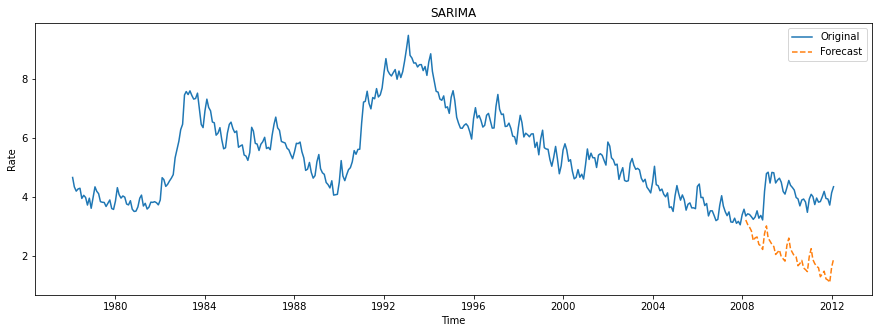

In [40]:
# Plot forecast and true values
plt.figure(figsize=(15,5))
plt.plot(rate,label='Original')
plt.plot(val.index, forecast,linestyle='--',label='Forecast')
plt.title('SARIMA')
plt.xlabel("Time")
plt.ylabel('Rate')
plt.legend()
plt.show()
#plt.savefig('Forecast with SARIMA .PNG')

In [41]:
mse_SARIMA = mse(forecast,val)
print("MSE in SARIMA {:.4f}".format(mse_SARIMA))
rmse_SARIMA = sqrt(mse_SARIMA)
print("RMSE in SARIMA {:.4f}".format(rmse_SARIMA))

MSE in SARIMA 4.2272
RMSE in SARIMA 2.0560


# Neural Networks

In [ ]:
import sys

!$sys.executable -m pip install tensorflow

In [42]:
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

In [43]:
import tensorflow as tf
import random
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

In [44]:

# Define a scaler object
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df)

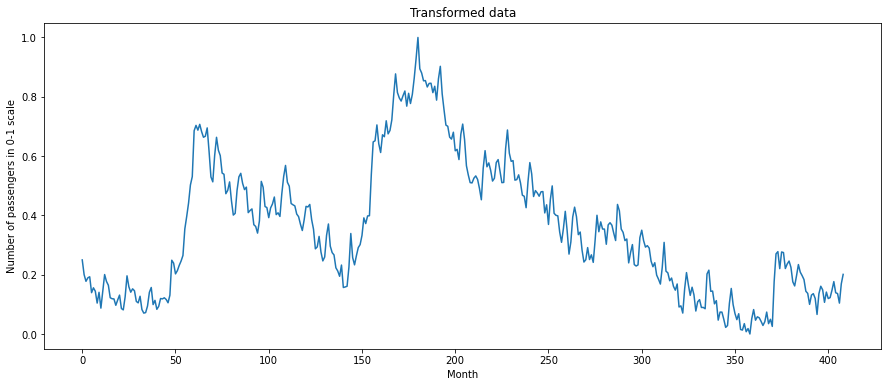

In [45]:
#plot transformed data
plt.figure(figsize=(15,6))
plt.plot(data)
plt.xlabel('Month')
plt.ylabel('Number of passengers in 0-1 scale')
plt.title('Transformed data')
plt.show()

In [46]:
# Time window to define the number of features in each row
time_window = 48 
# Pre-allocation
Xall, Yall = [], []

# Use each rolling window as a row in the data matrix 
for i in range(time_window, len(data)):  # 
    Xall.append(data[i-time_window:i, 0]) # (n-p) arrys from index 0-p-1 to index n-p-1  - n-2
    Yall.append(data[i, 0]) #(n-p) floats from index p to index n-1
# Convert them from list to array
Xall = np.array(Xall)
Yall = np.array(Yall) 

train_size = len(Xall)-48
test_size = 48
# Training data
Xtrain = Xall[:train_size, :]
Ytrain = Yall[:train_size]

# Test data
Xtest = Xall[-test_size:, :]
Ytest = Yall[-test_size:]

In [47]:
model = Sequential()
model.add(Dense(20, input_dim = time_window, activation='relu')) 
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                980       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [49]:
model.fit(Xall, Yall, epochs=400, batch_size=20 , verbose=1) 

Epoch 1/400
19/19 [==============================] - 1s 3ms/step - loss: 0.0732
Epoch 2/400
19/19 [==============================] - 0s 4ms/step - loss: 0.0184
Epoch 3/400
19/19 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 4/400
19/19 [==============================] - 0s 3ms/step - loss: 0.0110
Epoch 5/400
19/19 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 6/400
19/19 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 7/400
19/19 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 8/400
19/19 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 9/400
19/19 [==============================] - 0s 1ms/step - loss: 0.0073
Epoch 10/400
19/19 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 11/400
19/19 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 12/400
19/19 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 13/400
19/19 [=================

19/19 [==============================] - 0s 1ms/step - loss: 9.1267e-04
Epoch 200/400
19/19 [==============================] - 0s 1ms/step - loss: 8.3267e-04
Epoch 201/400
19/19 [==============================] - 0s 1ms/step - loss: 9.3166e-04
Epoch 202/400
19/19 [==============================] - 0s 1ms/step - loss: 7.4656e-04
Epoch 203/400
19/19 [==============================] - 0s 1ms/step - loss: 7.5663e-04
Epoch 204/400
19/19 [==============================] - 0s 1ms/step - loss: 8.0038e-04
Epoch 205/400
19/19 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 206/400
19/19 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 207/400
19/19 [==============================] - 0s 1ms/step - loss: 8.5750e-04
Epoch 208/400
19/19 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 209/400
19/19 [==============================] - 0s 1ms/step - loss: 8.4453e-04
Epoch 210/400
19/19 [==============================] - 0s 1ms/step - loss: 0.001

19/19 [==============================] - 0s 1ms/step - loss: 6.4136e-04
Epoch 391/400
19/19 [==============================] - 0s 2ms/step - loss: 6.1843e-04
Epoch 392/400
19/19 [==============================] - 0s 2ms/step - loss: 6.3901e-04
Epoch 393/400
19/19 [==============================] - 0s 2ms/step - loss: 7.6733e-04
Epoch 394/400
19/19 [==============================] - 0s 2ms/step - loss: 5.8063e-04
Epoch 395/400
19/19 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 396/400
19/19 [==============================] - 0s 2ms/step - loss: 6.8933e-04
Epoch 397/400
19/19 [==============================] - 0s 2ms/step - loss: 7.9256e-04
Epoch 398/400
19/19 [==============================] - 0s 2ms/step - loss: 7.0377e-04
Epoch 399/400
19/19 [==============================] - 0s 2ms/step - loss: 8.8610e-04
Epoch 400/400
19/19 [==============================] - 0s 2ms/step - loss: 0.0012


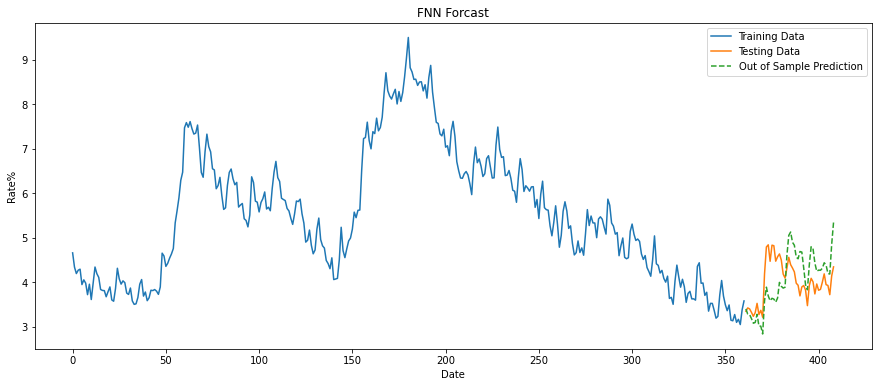

In [50]:
import math
from sklearn.metrics import mean_squared_error
dynamic_prediction = np.copy(data[:len(data) - test_size])

for i in range(len(data) - test_size, len(data)):
    #locate the input values and reshape them into (1,window_size)
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window))
    #use the lastest inpute values to get the new prediction results
    next_pred = model.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)

# Transform forecast values to original scale
dynamic_prediction = dynamic_prediction.reshape(-1,1)
dynamic_prediction = scaler.inverse_transform(dynamic_prediction)

# Plot forecast and test values
plt.figure(figsize=(15,6))
plt.plot(scaler.inverse_transform(data[:len(data) - test_size]), label='Training Data')

plt.plot(np.arange(len(data) - test_size, len(data), 1), scaler.inverse_transform(data[-test_size:]), label='Testing Data')

plt.plot(np.arange(len(data) - test_size, len(data), 1), dynamic_prediction[-test_size:], linestyle='--',label='Out of Sample Prediction') 

plt.legend(loc = "upper left")
plt.title('FNN Forcast')
plt.xlabel("Date")
plt.ylabel('Rate%')
plt.legend()
plt.show()
#plt.savefig('DNN Forcast .PNG')  


In [51]:
mse_DNN = mse(dynamic_prediction[-test_size:],scaler.inverse_transform(Ytest.reshape(-1,1)))
       
print('Dynamic Forecast MSE on original scale: {0:.4f}'.format(mse_DNN))

Dynamic Forecast MSE on original scale: 0.3708


# Recurrent NN

In [52]:
from tensorflow.keras.layers import LSTM

In [53]:
import tensorflow as tf
import random
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

In [54]:

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df)

In [55]:
# Pre-allocation
time_window = 48
Xall, Yall = [], []


# Use each rolling window as a row in the data matrix 
for i in range(time_window, len(data)):
    Xall.append(data[i-time_window:i, 0])
    Yall.append(data[i, 0])

# Convert them from list to array
Xall = np.array(Xall)
Yall = np.array(Yall)

train_size = len(Xall)-48
test_size = 48
# Training data
Xtrain = Xall[:train_size, :]
Ytrain = Yall[:train_size]

# Test data
Xtest = Xall[-test_size:, :]
Ytest = Yall[-test_size:]

In [56]:
# For time series and LSTM layer we need to reshape into 3D array
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], time_window, 1))
Xtest = np.reshape(Xtest, (Xtest.shape[0], time_window, 1))
Xall = np.reshape(Xall, (Xall.shape[0],time_window,1))

In [57]:
model = Sequential()
# Add a LSTM with units (number of hidden neurons) = 24
# input_dim = 1 (for time series)
# return sequences = False (default) means the RNN layer will only return the last hidden state output

model.add(LSTM(input_shape = (None,1), 
               units = 48, 
               activation = 'relu', 
               return_sequences = False)) 
model.add(Dense(units=1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")

In [58]:
from keras.callbacks import EarlyStopping 

early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1)

In [59]:
model.fit(Xtrain, Ytrain, 
          batch_size = 20,             
          epochs = 400,               
          validation_split = 0.1, 
          shuffle = False,
          verbose = 0, 
          callbacks = [early_stop])



Epoch 00311: early stopping


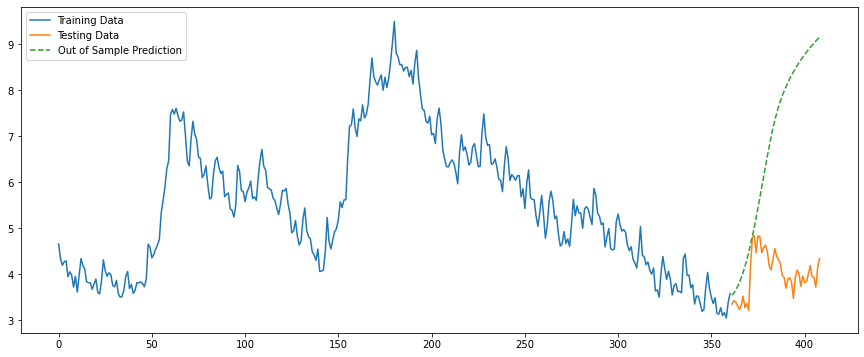

In [60]:
#Dynamical Prediction
dynamic_prediction = np.copy(data[:len(data) - test_size])

for i in range(len(data) - test_size, len(data)):
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window,1))
    next_pred = model.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)

# Transform forecast values to original scale
dynamic_prediction = dynamic_prediction.reshape(-1,1)
dynamic_prediction_original_scale = scaler.inverse_transform(dynamic_prediction)

# Plot
test_index = np.arange(len(data) - test_size, len(data), 1)

plt.figure(figsize=(15,6))
plt.plot(scaler.inverse_transform(data[:len(data) - test_size]), label='Training Data')
plt.plot(test_index, scaler.inverse_transform(data[-test_size:]), label='Testing Data')
plt.plot(test_index, dynamic_prediction_original_scale[-test_size:], linestyle='--',label='Out of Sample Prediction') 
plt.legend(loc = "upper left")
plt.show()



In [61]:
mse_RNN = mse(dynamic_prediction[-test_size:],scaler.inverse_transform(Ytest.reshape(-1,1)))
print('Dynamic Forecast MSE on original scale: {0:.4f}'.format(mse_RNN))

Dynamic Forecast MSE on original scale: 11.8885


 # Final Prediction

In [62]:
rate = df['UnemploymentRate']

In [63]:
col = ['MSE']
index = ['Additive decomposition','SES','Holt Winter add','ARIMA 5-1-4','SARIMA','Neural Networks','RNN']
MSE = np.array([mse_decomposition,mse_SES,mse_add,mse_ARIMA,mse_SARIMA,mse_DNN,mse_RNN])
summary = pd.DataFrame(MSE, index=index, columns=col)
summary['RMSE']=summary**0.5
summary

,MSE,RMSE
Additive decomposition,1.626281,1.275257
SES,0.389873,0.624398
Holt Winter add,4.347273,2.085012
ARIMA 5-1-4,0.658483,0.811470
SARIMA,4.227236,2.056024
Neural Networks,0.370764,0.608904
RNN,11.888461,3.447965


# NN

In [1]:
import tensorflow as tf
import random
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)
data = scaler.fit_transform(df)

ModuleNotFoundError: No module named 'tensorflow'

In [65]:
model = Sequential()
model.add(Dense(20, input_dim = time_window, activation='relu'))  
model.add(Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                980       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


In [66]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [67]:
time_window = 48

final_test_size = 48

dynamic_prediction = np.copy(data)

for i in range(len(data) - final_test_size, len(data)):
    #locate the input values and reshape them into (1,window_size)
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window))
    #use the lastest inpute values to get the new prediction results
    next_pred = model.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)

# Transform forecast values to original scale
dynamic_prediction = dynamic_prediction.reshape(-1,1)
dynamic_prediction = scaler.inverse_transform(dynamic_prediction)

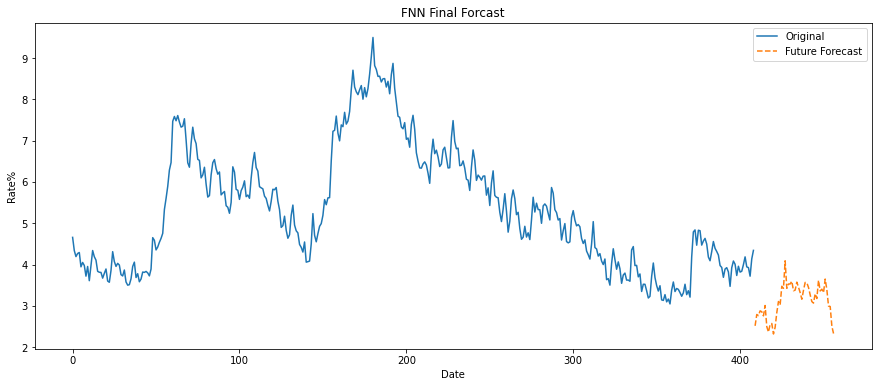

In [68]:
#plot
plt.figure(figsize=(15,6))
plt.plot(scaler.inverse_transform(data), label='Original')

#plt.plot(np.arange(len(data) + final_test_size, len(data), 1), scaler.inverse_transform(data[-test_size:]), label='Testing Data')

plt.plot(np.arange(len(data),len(data) + final_test_size, 1), dynamic_prediction[-final_test_size:], linestyle='--',label='Future Forecast') 

plt.legend(loc = "upper left")
plt.title('FNN Final Forcast')
plt.xlabel("Date")
plt.ylabel('Rate%')
plt.legend()
plt.show()
#plt.savefig('DNN Forcast .PNG')  

In [69]:
final_forecast = dynamic_prediction[-final_test_size:]
df_test = pd.read_csv('unemployment_Rate_test.csv')
final_MSE = mse(final_forecast,df_test['UnemploymentRate'].values)
print('Final MSE in FNN',round(final_MSE,4))

Final MSE in FNN 9.9446
